<a href="https://colab.research.google.com/github/wesleybeckner/data_science_foundations/blob/main/notebooks/S3_Model_Selection_and_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Foundations, Session 3: Model Selection and Validation

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

---

<br>

At the end of session 1, we saw the basic recipe for creating a supervised machine learning model:

1. Environment setup and importing data
2. Rudimentary exploratory data analysis
3. Feature engineering (these were created for us)
4. Choosing and training a model:
    1. choose model
    2. choose hyperparameters
    3. fit using (training) data
    4. predict using (validation) data

In session 1, I chose our model and hyperparameters preemptively. How did I do that? In the real world, you won't necessarily have the best intution about how to make these choices. In today's session, we will algorithmize the way we approach choosing and training a model

Note: I will import libraries at the beginning of this notebook, as is good practice, but will reimport them as they are used to remind ourselves where each method came from!

<br>

---

<br>

<a name='top'></a>

<a name='x.0'></a>

## 3.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 3.0.1 Import Packages

[back to top](#top)

In [81]:
# Pandas library for the pandas dataframes
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats as stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.datasets import load_iris

<a name='x.0.2'></a>

### 3.0.2 Load Dataset

[back to top](#top)

In session 1 we cursorily discussed why we may need strategies for validating our model. Here we'll discuss it more in depth. 

I'm going to take a simple example. In the following, I have a dataset that contains some data about flowers. It's a very famous dataset used in the ML world

In [82]:
iris = load_iris()
X = iris.data
y = iris.target

In [83]:
print(X.shape)
print(y.shape)

(150, 4)
(150,)


let's go ahead and load our wine dataset as well...

In [119]:
wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

In [120]:
wine.dropna(inplace=True)
wine['quality_label'] = wine['quality'].apply(lambda x: 'low' if x <=5 else
                                              'med' if x <= 7 else 'high')
class_tp = {'red': 0, 'white': 1}
y_tp = wine['type'].map(class_tp)
wine['type_encoding'] = y_tp

class_ql = {'low':0, 'med': 1, 'high': 2}
y_ql = wine['quality_label'].map(class_ql)
wine['quality_encoding'] = y_ql

wine.drop(['type', 'quality_label', 'quality'], axis=1, inplace=True)

wine.columns = wine.columns.str.replace(' ', '_')
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_encoding,quality_encoding
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1


<a name='1.1'></a>

## 3.1 Model Validation

[back to top](#top)

*doing it the wrong way*<br>

While we're here, I'm going to introduce a VERY SIMPLE supervised learning method called K-Nearest Neighbors.

<a name='x.1.0'></a>

### 3.1.0 K-Nearest Neighbors

[back to top](#top)

K-Nearest Neighbors is perhaps the simplest algorithm of them all. It is essentially a lookup table: We select the hyperparameter K, and when assigning a new value a data label, assign it according to, the majority label in the vicinity of the new datapoint. The vicinity being determined by K, the number of nearest neighbors we are going to assess.

In [86]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X,y)

KNeighborsRegressor(n_neighbors=1)

In [87]:
knn.score(X,y)

1.0

Wow! we achieved a model with a perfect score! But is this really how we would expect the model to perform on data it had never seen before? Probably not. How do we actually check the performance of our model?

<a name='1.1.1'></a>

### 3.1.1 Holdout Sets

[back to top](#top)

The way we account for unseen data, in practice, is to leave a portion of the dataset out for testing. This way, we can estimate how our model will perform on entirely new data it may come across in application.

In [88]:
train_size=0.6
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train,y_train)
print(knn.score(X_test, y_test))

0.9753593429158111


We see that we get a more reasonable value for our performance!

<a name='1.1.2'></a>

### 3.1.2 Data Leakage and Cross-Validation

[back to top](#top)

An even more rigorous method to leaving out a single test set, is to perform cross validation. Imagine a situation where we are trying to estimate the best value of K in our KNN algorithm. If we continually train our model with new values of K on our training set, and test with our testing set, "knowledge" of our test set values with leak into our model, as we choose the best value for K based on how it performs on our test set (even though we did not train on this test set). We call this phenomenon *data leakage*. CV or Cross Validation overcomes this by only evaluating our parameters with our training set.

<p align="center">
<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' width=500px></img>
</p>

<small>[img src](https://scikit-learn.org/stable/modules/cross_validation.html)</small>


In this scheme, we don't evaluate our model on the test set until the very end. Rather, we estimate our hyperparameter performances by slicing the training set into cross folds

<p align="center">
<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' width=500px></img>
</p>

<small>[img src](https://scikit-learn.org/stable/modules/cross_validation.html)</small>




In [89]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X_train, y_train, cv=5)

In [90]:
scores

array([0.91666667, 0.81725888, 0.85714286, 1.        , 0.91      ])

In [91]:
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

0.90 accuracy with a standard deviation of 0.062


More information on the cross_val_score method in sklearn can be found [here](https://scikit-learn.org/stable/modules/cross_validation.html)

An additional topic on cross validation is the extreme leave-one-out validation, you can read more about that [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Model-validation-via-cross-validation)

Taking these building blocks, if we wanted to for example optimize the number of nearest neighbors without incurring data leakage. We might take the following approach:

In [92]:
for k in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    print("k=%0.0f, %0.3f accuracy with a standard deviation of %0.3f" % (k, scores.mean(), scores.std()))

k=1, 0.900 accuracy with a standard deviation of 0.062
k=2, 0.925 accuracy with a standard deviation of 0.071
k=3, 0.916 accuracy with a standard deviation of 0.077
k=4, 0.932 accuracy with a standard deviation of 0.046
k=5, 0.928 accuracy with a standard deviation of 0.045
k=6, 0.924 accuracy with a standard deviation of 0.047
k=7, 0.929 accuracy with a standard deviation of 0.041
k=8, 0.924 accuracy with a standard deviation of 0.047
k=9, 0.923 accuracy with a standard deviation of 0.042


In [93]:
k = 4 # select best hyperparameters
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train,y_train) # final train
print(knn.score(X_test, y_test))

0.9845995893223819


<a name='1.1.3'></a>

### 3.1.3 Bias-Variance Tradeoff

[back to top](#top)

This next concept will be most easily understood if we go ahead an make up some data ourselves, I'm going to do that now.

Text(0, 0.5, 'Y')

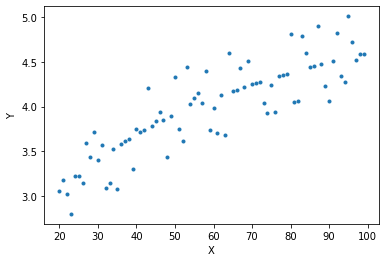

In [94]:
# we can throttle the error rate
err = .5
random.seed(42)

# our data has a KNOWN underlying functional form (log(x))
def func(x, err):
  return np.log(x) + err * random.randint(-1,1) * random.random()
x = np.arange(20,100)
y = [func(t, err) for t in x]
plt.plot(x, y, ls='', marker='.')
plt.xlabel('X')
plt.ylabel('Y')

Let's fit to just a portion of this data

In [95]:
random.seed(42)
X_train = random.sample(list(x), 10)

indices = [list(x).index(i) for i in X_train]
# we could also do it this way: np.argwhere([i in X_train for i in x])

y_train = [y[i] for i in indices]

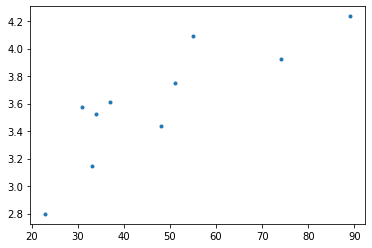

In [96]:
plt.plot(X_train,y_train, ls='', marker='.')

Now let's take two extreme scenarios: fitting to these datapoints a linear line and a high order polynomial. Keeping in mind the larger dataset (the population) as well as the (irreducible) error we introduced in our data generating function will really illustrate our point!

Text(0.5, 1.0, 'High Variance Model')

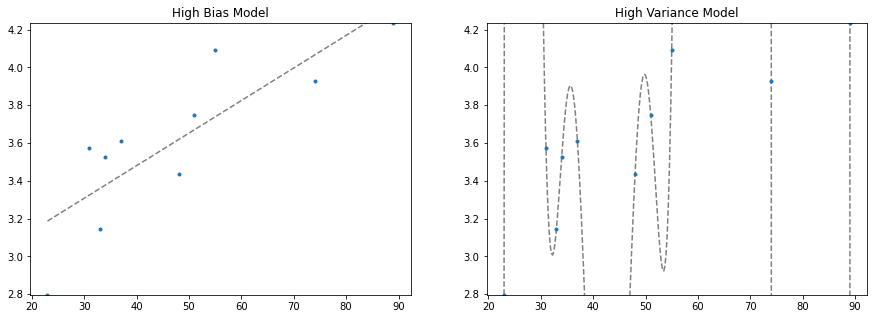

In [97]:
# solving our training data with a n-degree polynomial
coefs = np.polyfit(X_train, y_train, 9)

# solve the slope and intercept of our 1-degree polynomial ;)
model = LinearRegression()
model.fit(np.array(X_train).reshape(-1,1), y_train)

# create some x data to plot our functions
X_seq = np.linspace(min(X_train),max(X_train),300).reshape(-1,1)

fig, ax = plt.subplots(1,2,figsize=(15,5))

# plot linear model
ax[0].plot(X_seq, model.predict(X_seq), c='grey', ls='--')
ax[0].plot(X_train, y_train, ls='', marker='.')
ax[0].set_ylim(min(y_train), max(y_train))
ax[0].set_title("High Bias Model")

# plot polynomial model
ax[1].plot(X_seq, np.polyval(coefs, X_seq), c='grey', ls='--')
ax[1].plot(X_train, y_train, ls='', marker='.')
ax[1].set_ylim(min(y_train), max(y_train))
ax[1].set_title("High Variance Model")

We've demonstrated two extreme cases. On the left, we limit our regression to only two parameters, a slope and a y-intercept. We say that this model has *high bias* because we are forcing the functional form without much consideration to the underlying data &mdash; we are saying this data is generated by a linear function, and no matter what data I train on, my final model will still be a straight line that more or less appears the same. Put another way, it has *low variance* with respect to the underlying data. 

On the right, we've allowed our model just as many polynomials it needs to perfectly fit the training data! We say this model has *low bias* because we don't introduce many constraints on the final form of the model. it is *high variance* because depending on the underlying training data, the final outcome of the model can change quite drastically!

In reality, the best model lies somewhere between these two cases. In the next few paragraphs we'll explore this concept further:

1. what happens when we retrain these models on different samples of the data **population**
    * and let's use this to better understand what we mean by *bias* and *variance*
2. what happens when we tie this back in with the **irreducible error** we introduced to the data generator?
    * and let's use this to better understand irreducible error

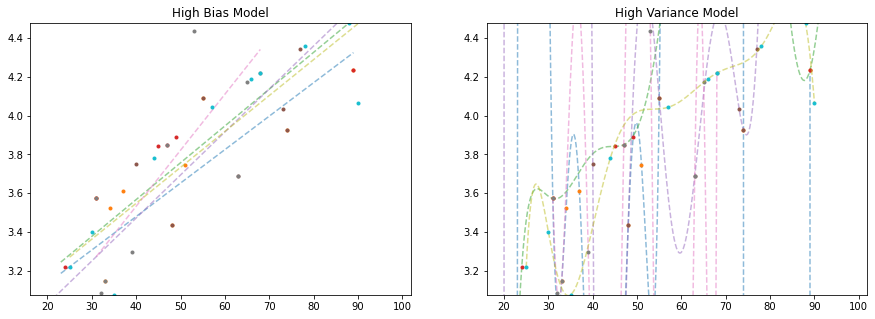

In [98]:
# we're going to perform this task again, but this time for 5 rounds, training
# on different samples of the population data

random.seed(42)
fig, ax = plt.subplots(1,2,figsize=(15,5))
for samples in range(5):
  X_train = random.sample(list(x), 10)
  indices = [list(x).index(i) for i in X_train]
  y_train = [y[i] for i in indices]

  # solving our training data with a n-degree polynomial
  coefs = np.polyfit(X_train, y_train, 9)

  # solve the slope and intercept of our 1-degree polynomial ;)
  model = LinearRegression()
  model.fit(np.array(X_train).reshape(-1,1), y_train)

  # create some x data to plot our functions
  X_seq = np.linspace(min(X_train),max(X_train),300).reshape(-1,1)

  
  ax[0].plot(X_seq, model.predict(X_seq), alpha=0.5, ls='--')
  ax[0].plot(X_train, y_train, ls='', marker='.')
  ax[0].set_ylim(min(y_train), max(y_train))
  ax[0].set_title("High Bias Model")


  ax[1].plot(X_seq, np.polyval(coefs, X_seq), alpha=0.5, ls='--')
  ax[1].plot(X_train, y_train, ls='', marker='.')
  ax[1].set_ylim(min(y_train), max(y_train))
  ax[1].set_title("High Variance Model")

As we can see, depending on what data we train our model on, the *high bias* model changes relatively slightly, while the *high variance* model changes a whole awful lot!

The *high variance* model is prone to something we call *overfitting*. It fits the training data very well, but at the expense of creating a good, generalizable model that does well on unseen data. 

Let's take our last models, and plot them along the rest of the unseen data, what we'll call the *population*:

Text(0.5, 1.0, 'High Variance Model')

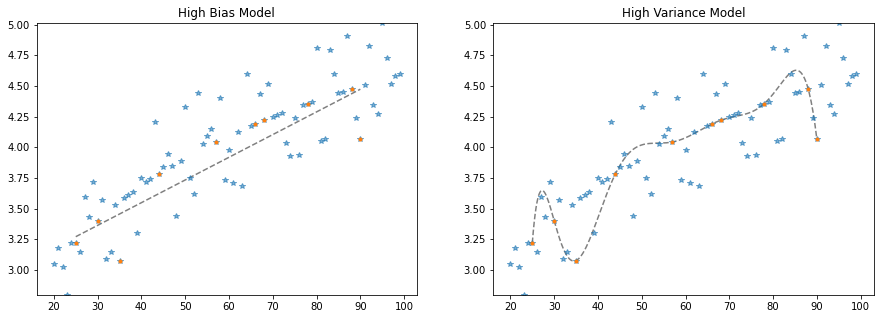

In [99]:
# solving our training data with a n-degree polynomial
coefs = np.polyfit(X_train, y_train, 9)

# solve the slope and intercept of our 1-degree polynomial ;)
model = LinearRegression()
model.fit(np.array(X_train).reshape(-1,1), y_train)

# create some x data to plot our functions
X_seq = np.linspace(min(X_train),max(X_train),300).reshape(-1,1)

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(X_seq, model.predict(X_seq), c='grey', ls='--')
ax[0].plot(x, y, ls='', marker='*', alpha=0.6)
ax[0].plot(X_train, y_train, ls='', marker='.')
ax[0].set_ylim(min(y), max(y))
ax[0].set_title("High Bias Model")


ax[1].plot(X_seq, np.polyval(coefs, X_seq), c='grey', ls='--')
ax[1].plot(x, y, ls='', marker='*', alpha=0.6)
ax[1].plot(X_train, y_train, ls='', marker='.')
ax[1].set_ylim(min(y), max(y))
ax[1].set_title("High Variance Model")

In particular, we see that the high variance model is doing very wacky things, demonstrating behaviors in the model where the underlying population data really gives no indication of such behavior. We say that these high variance models are particuarly prone to the phenomenon of *over fitting* and this is generally due to the fact that there is irreducible error in the underlying data. Let's demonstrate this.

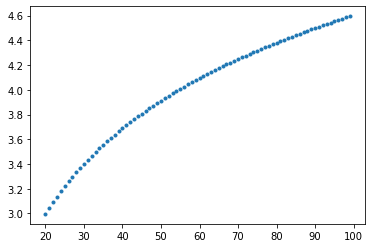

In [100]:
x = np.arange(20,100)
y = [func(t, err=0) for t in x]
plt.plot(x,y, ls='', marker='.')

Text(0.5, 1.0, 'High Variance Model')

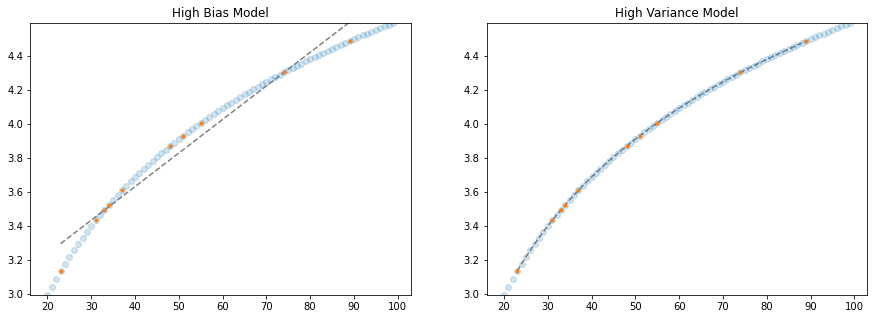

In [101]:
random.seed(42)
X_train = random.sample(list(x), 10)

indices = [list(x).index(i) for i in X_train]
# we could also do it this way: np.argwhere([i in X_train for i in x])

y_train = [y[i] for i in indices]

# solving our training data with a n-degree polynomial
coefs = np.polyfit(X_train, y_train, 9)

# solve the slope and intercept of our 1-degree polynomial ;)
model = LinearRegression()
model.fit(np.array(X_train).reshape(-1,1), y_train)

# create some x data to plot our functions
X_seq = np.linspace(min(X_train),max(X_train),300).reshape(-1,1)

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(X_seq, model.predict(X_seq), c='grey', ls='--')
ax[0].plot(x, y, ls='', marker='o', alpha=0.2)
ax[0].plot(X_train, y_train, ls='', marker='.')
ax[0].set_ylim(min(y), max(y))
ax[0].set_title("High Bias Model")


ax[1].plot(X_seq, np.polyval(coefs, X_seq), c='grey', ls='--')
ax[1].plot(x, y, ls='', marker='o', alpha=0.2)
ax[1].plot(X_train, y_train, ls='', marker='.')
ax[1].set_ylim(min(y), max(y))
ax[1].set_title("High Variance Model")

This time, our high variance model really *gets it*! And this is because the data we trained on actually *is* a good representation of the entire population. But this, in reality, almost never, ever happens. In the real world, we have irreducible error in our data samples, and we must account for this when choosing our model. 

I'm summary, we call this balance between error in our model functional form, and error from succumbing to irreducible error in our training data, the *bias variance tradeoff*

#### 🏋️ Exercise 1: Quantitatively Define Performance

Up until now, we've explored this idea of bias variance tradeoff from a qualitative standpoint. As an exercise, continue with this idea, this time calculating the mean squared error (MSE) and R-square between the model and UNSEEN (non-training data) population data. 

error metrics

* `r2_score` 
* `mean_squared_error`

Do this for a 9th order polynomial and repeat for population data with low, med, and high degrees of error and small and large training fractions (for 6 total comparisons). Complete the chart below.

| error | training fraction | MSE | R2 |
|-------|-------------------|-----|----|
|       |                   |     |    |
|       |                   |     |    |
|       |                   |     |    |
|       |                   |     |    |
|       |                   |     |    |
|       |                   |     |    |

In [102]:
# Code Cell for Exercise 1
from sklearn.preprocessing import PolynomialFeatures
random.seed(42)

# function to generate data
def func(x, err):
  return np.log(x) + err * random.randint(-1,1) * random.random()
x = np.arange(20,100)

################################################################################
########## CHANGE ERR TO CHANGE THE AMOUNT OF NOISE IN YOUR DATA ###############
################################################################################
# err = <YOUR ERR> # change the error (.1 - 0.9)
y_actual = [func(t, err) for t in x]


################################################################################
############# CHANGE TRAIN_SIZE TO SAMPLE THE DATA FOR TRAINING ################
################################################################################
# train_size=<YOUR NUMBER>, # change the training size
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y_actual,
                                                    train_size=train_size,
                                                    random_state=42)

# solving our training data with a 9-degree polynomial
coefs = np.polyfit(x_train, y_train, 9)

# generate y data with 9-degree polynomial model and X_seq
y_pred = np.polyval(coefs, x_test)

################################################################################
############################## CALCULATE MSE AND R2 ############################
################################################################################
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# look at results
print("mean square error: {:.2f}".format(mse))
print("r2: {:.2f}".format(r2))

mean square error: 0.08
r2: 0.63


<a name='1.1.4'></a>

### 3.1.4 Learning Curves

[back to top](#top)

To move from qualitative to quantitative understanding of bias-variance tradeoff we need to introduce some metric for model performance. A good one to use here is R-square, a measure of the degree to which predictions match actual values. We can import a tool from sklearn to calculate this for us.



In [103]:
from sklearn.metrics import r2_score

<a name='x.1.4.1'></a>

#### 3.1.4.1 Considering Model Complexity

[back to top](#top)

In a learning curve, we will typically plot the training and testing scores together, to give a sense of when we have either too much bias or too much variance in our model.

I'm going to go ahead and recreate the original data distribution we introduced in 1.1.3

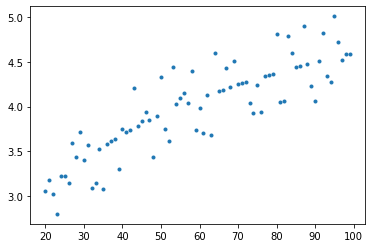

In [104]:
# we can throttle the error rate
err = .5
random.seed(42)

# our data has a KNOWN underlying functional form (log(x))
def func(x, err):
  return np.log(x) + err * random.randint(-1,1) * random.random()
x = np.arange(20,100)
y = [func(t, err) for t in x]
plt.plot(x,y, ls='', marker='.')

Now let's itteratively introduce more complexity into our model

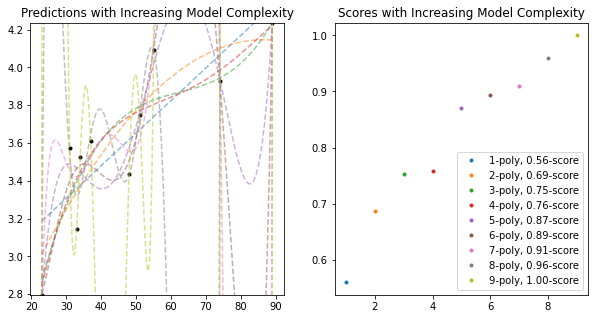

In [105]:
random.seed(42)
fig, ax = plt.subplots(1,2,figsize=(10,5))
X_train = random.sample(list(x), 10)
indices = [list(x).index(i) for i in X_train]
y_train = [y[i] for i in indices]
ax[0].plot(X_train, y_train, ls='', marker='.', color='black')
for complexity in range(1,10):
  

  # solving our training data with a n-degree polynomial
  coefs = np.polyfit(X_train, y_train, complexity)

    # create some x data to plot our functions
  X_seq = np.linspace(min(X_train),max(X_train),300).reshape(-1,1)

  score = r2_score(np.polyval(coefs, X_train), y_train)
  ax[0].plot(X_seq, np.polyval(coefs, X_seq), alpha=0.5, ls='--')
  ax[0].set_ylim(min(y_train), max(y_train))
  ax[0].set_title("Predictions with Increasing Model Complexity")

  ax[1].plot(complexity, score, ls='', marker='.',
          label='{}-poly, {:.2f}-score'.format(complexity, score))
  ax[1].set_title("Scores with Increasing Model Complexity")
ax[1].legend()

As we see from both plots, the score on the training data increases with added model complexity. Giving us the expected perfect fit when the order is the same as the number of data points! This is part I of our learning curve. Part II consists of plotting the training data score with the testing data score.

Something else I'm going to do, is _define the training portion of the data as a fraction of the overall dataset_. This is a typical practice in machine learning. To keep the comparisons the same as up until now, I will keep this training fraction low at .2

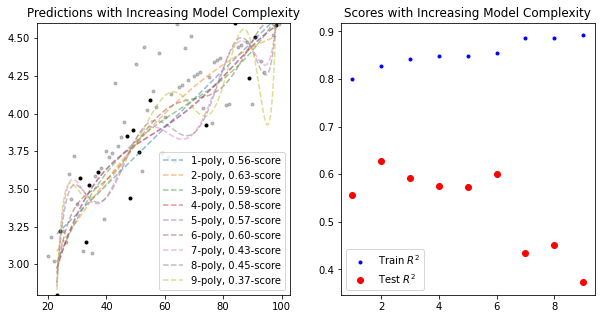

In [106]:
random.seed(42)

# defining my training fraction
training_frac = .2

# create test and training data
X_train = random.sample(list(x), int(int(len(x))*training_frac))
train_indices = [list(x).index(i) for i in X_train]
y_train = [y[i] for i in train_indices]
test_indices = [i for i in range(len(x)) if i not in train_indices]
X_test = [x[i] for i in test_indices]
y_test = [y[i] for i in test_indices]

# initialize the plot and display the data
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(X_train, y_train, ls='', marker='.', color='black')
ax[0].plot(X_test, y_test, ls='', marker='.', color='grey', alpha=0.5)
for complexity in range(1,10):

  # solving our training data with a n-degree polynomial
  coefs = np.polyfit(X_train, y_train, complexity)

  # create some x data to plot our functions
  X_seq = np.linspace(min(X_train),max(X_train),300).reshape(-1,1)

  score1 = r2_score(np.polyval(coefs, X_train), y_train)
  score2 = r2_score(np.polyval(coefs, X_test), y_test)
  ax[0].plot(X_seq, np.polyval(coefs, X_seq), alpha=0.5, ls='--',
             label='{}-poly, {:.2f}-score'.format(complexity, score2))
  ax[0].set_ylim(min(y_train), max(y_train))
  ax[0].set_title("Predictions with Increasing Model Complexity")

  ax[1].plot(complexity, score1, ls='', marker='.', color='blue',
          label='{}-poly, {:.2f}-score'.format(complexity, score1))
  ax[1].plot(complexity, score2, ls='', marker='o', color='red',
          label='{}-poly, {:.2f}-score'.format(complexity, score2))
  ax[1].set_title("Scores with Increasing Model Complexity")
  
ax[1].legend(['Train $R^2$', 'Test $R^2$'])
ax[0].legend()

As we can see, The 2nd order polynomial achieves the greatest best test set data \\(R^2\\), while the highest order polynomial achieves the best training set data \\(R^2\\). This learning curve is explanative of what we see generally, namely a divergence after some degree of complexity between training and test set performances. In this case, we would resolve to choose the 2nd order polynomial as the best model for our data.

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png" width=500px></img>

<small>[img src](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)</small>



<a name='x.1.4.2'></a>

#### 3.1.4.2 Considering Training Set Size

[back to top](#top)

The last piece of the puzzle we require, to fully cover learning curves, is the effect of training data size on the model. 

Let's explore.

Text(0, 0.5, '$R^2$')

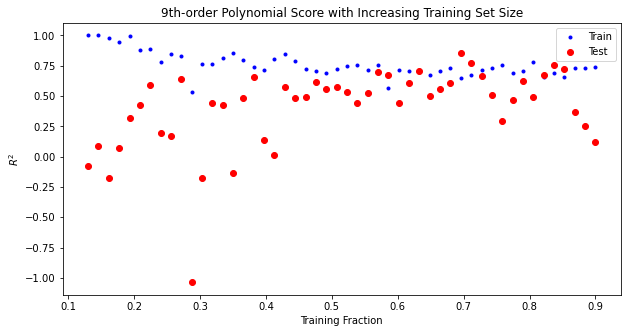

In [107]:
random.seed(42)
# initialize the plot and display the data
fig, ax = plt.subplots(1,1,figsize=(10,5))
for training_frac in np.linspace(0.13,.9,50):
  # create test and training data
  X_train = random.sample(list(x), int(int(len(x))*training_frac))
  indices = [list(x).index(i) for i in X_train]
  y_train = [y[i] for i in indices]
  test_indices = [i for i in range(len(x)) if i not in indices]
  X_test = [x[i] for i in test_indices]
  y_test = [y[i] for i in test_indices]
  
  # solving our training data with a n-degree polynomial
  coefs = np.polyfit(X_train, y_train, 9)

  score1 = r2_score(np.polyval(coefs, X_train), y_train)
  score2 = r2_score(np.polyval(coefs, X_test), y_test)

  ax.plot(training_frac, score1, ls='', marker='.', color='blue',
          label='{}-poly, {:.2f}-score'.format(training_frac, score1))
  ax.plot(training_frac, score2, ls='', marker='o', color='red',
          label='{}-poly, {:.2f}-score'.format(training_frac, score2))
  ax.set_title("9th-order Polynomial Score with Increasing Training Set Size")
ax.legend(['Train','Test'])
ax.set_xlabel('Training Fraction')
ax.set_ylabel('$R^2$')

What we see here is a trend that happens generally, as our amount of training data increases, our models handle more complexity. This is because the more data we have, the more we are able to dicipher noise from signal. Our model will ignore noise as it does not generalize well across the other datapoints. Instead, it will will fit to relationships that appear across the entire training dataset. 

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-learning-curve.png" width=500px></img>

<small>[img src](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)

#### 🏋️ Exercise 2: Visualization

Starting with the code below, make a side-by-side plot of a 3rd degree polynomial and a 9th degree polynomial. On the x axis slowly increase the training set size, on the y axis plot the scores for the training and test sets.

Text(0, 0.5, '$R^2$')

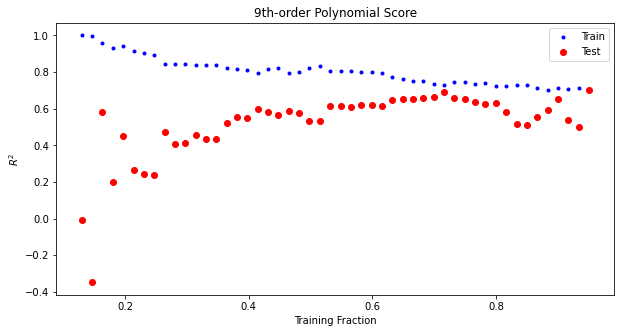

In [108]:
# Code Cell for Exercise 2
random.seed(42)

# create the figure and axes
fig, ax = plt.subplots(1,1,figsize=(10,5))

for training_frac in np.linspace(0.13,.95,50):

  # create test and training data
  x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y_actual,
                                                    train_size=training_frac, 
                                                    random_state=42)
  
  # solving our training data with a n-degree polynomial
  coefs = np.polyfit(x_train, y_train, 9)

  # recording the scores for the training and test sets
  score1 = r2_score(np.polyval(coefs, x_train), y_train)
  score2 = r2_score(np.polyval(coefs, x_test), y_test)

  ax.plot(training_frac, score1, ls='', marker='.', color='blue',
          label='{}-poly, {:.2f}-score'.format(training_frac, score1))
  ax.plot(training_frac, score2, ls='', marker='o', color='red',
          label='{}-poly, {:.2f}-score'.format(training_frac, score2))
  ax.set_title("9th-order Polynomial Score")

ax.legend(['Train','Test'])
ax.set_xlabel('Training Fraction')
ax.set_ylabel('$R^2$')

#### 🙋‍♀️ Question 1: In what regions of the plots are we overfitting?

Where in these plots is overfitting occuring? Why is it different for each polynomial?

<a name='1.2'></a>

## 3.2 Model Validation in Practice

[back to top](#top)

We will now turn our attention to practical implementation.

In practice, there are a wide number of variables (called hyperparameters) to consider when choosing a model. Scikit learn has a useful method called Grid Search that will iterate through every possible combination of a range of hyperparameter settings you provide as input. 

Before we get started with grid search, we'll need to switch over from our numpy polynomial fit method to one in sklearn. Here, the caveat is our actual model will solve for the *coefficients* infront of the polynomials. We will *engineer* the polynomial features ourselves. This is an example of *feature engineering* which we will revisit in depth in the next session.

In [109]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

<a name='1.2.1'></a>

### 3.2.1 Grid Search

[back to top](#top)



In [110]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(10),
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [111]:
# create test and training data
random.seed(42)
X_train = random.sample(list(x), int(int(len(x))*.8))
indices = [list(x).index(i) for i in X_train]
y_train = [y[i] for i in indices]
test_indices = [i for i in range(len(x)) if i not in indices]
X_test = [x[i] for i in test_indices]
y_test = [y[i] for i in test_indices]

In [112]:
grid.fit(np.array(X_train).reshape(-1,1), y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'polynomialfeatures__degree': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [113]:
grid.best_params_

{'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 3}

to grab the best model from the CV/search outcome. we use grid.best_estimator

Text(0.5, 1.0, 'Best Grid Search CV Model')

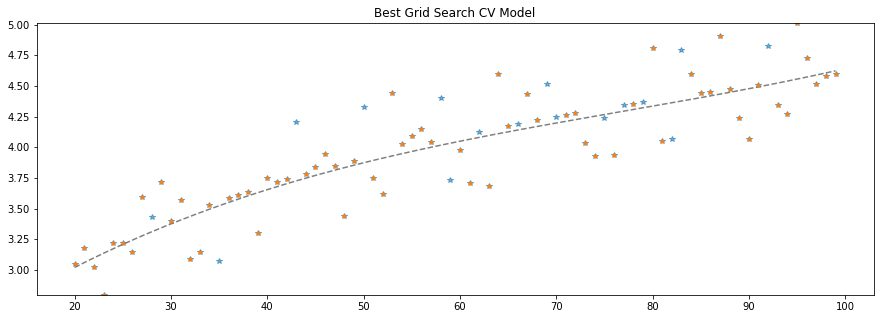

In [114]:
model = grid.best_estimator_

# create some x data to plot our functions
X_seq = np.linspace(min(X_train), max(X_train), 300).reshape(-1,1)

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(X_seq, model.predict(X_seq), c='grey', ls='--')
ax.plot(x, y, ls='', marker='*', alpha=0.6)
ax.plot(X_train, y_train, ls='', marker='.')
ax.set_ylim(min(y), max(y))
ax.set_title("Best Grid Search CV Model")

#### 🏋️ Exercise 3: Grid Search

There are two objectives for this exercise:

1. Complete the object `param_grid` by reading the parameters below in [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler). We would like to include in our grid search whether or not to scale our input features so that they are centered at 0 (`with_mean`) and have unit variance (`with_std`)

2. After you have completed the grid search, create a side-by-side plot of actual versus predicted values for training data (left plot) and testing data (right plot)

3. Include in your plot title the R2 for testing and R2 for training

In [121]:
df = wine.copy()
y = df.pop('density')
X = df

display(X.head())
display(y.head())
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

def NormalizedRegression(**kwargs):
    return make_pipeline(StandardScaler(),
                         LinearRegression(**kwargs))

######################################################################################################
####################### YOUR EXTRA PARAMETERS GO IN THE DICTIONARY BELOW #############################
######################################################################################################
param_grid = {'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(NormalizedRegression(), param_grid, cv=5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,type_encoding,quality_encoding
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,3.00,0.45,8.8,1,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,3.30,0.49,9.5,1,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,3.26,0.44,10.1,1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,3.19,0.40,9.9,1,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,3.19,0.40,9.9,1,1


0    1.0010
1    0.9940
2    0.9951
3    0.9956
4    0.9956
Name: density, dtype: float64

(6463, 12)
(6463,)


In [122]:
grid.fit(X_train, y_train)
print(grid.best_params_)

{'linearregression__fit_intercept': True}


Text(0.5, 1.0, 'Best Grid Search CV Model')

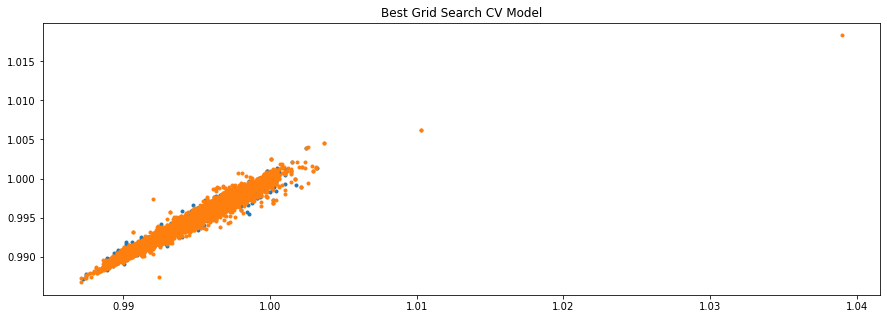

In [123]:
model = grid.best_estimator_

######################################################################################################
##################################### ADJUST THE PLOT LOGIC BELOW ####################################
######################################################################################################

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(y_test, model.predict(X_test), ls='', marker='.')
ax.plot(y_train, model.predict(X_train), ls='', marker='.')

ax.set_title("Best Grid Search CV Model")

<a name='reference'></a>

# References

[back to top](#top)

## Model Validation

* [cross_val_score](https://scikit-learn.org/stable/modules/cross_validation.html)
* [leave-one-out](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Model-validation-via-cross-validation)